# CPSS Data Analysis - Modat Service Dataset
## Analysis 1: Basic Statistics and Distribution

This notebook analyzes the collected CPSS service data to produce:
- Summary statistics
- CPSS device identification
- Service distribution analysis
- CVE exposure analysis
- Geographic and ASN distribution
- Visualizations exported to ./output/

**Input:**
- `./input/[latest .txt file]` - NIDV domains
- `./staging/3_prepare_analyses/1_ipv4_statistics.txt` - IPv4 collection stats
- `./staging/3_prepare_analyses/modat_service_all.csv` - Service data

**Output:** All files prefixed with `analyses_1_` in `./output/1_data_statistics`

## Configuration


In [26]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime
import warnings
import json
from collections import Counter
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Create output directory if it doesn't exist
output_dir = Path('./output/1_data_statistics')
output_dir.mkdir(exist_ok=True)

print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {output_dir.absolute()}\n")


# ========================================
# Add full COLORS dictionary at the top of notebook
# ========================================

COLORS = {
    # === Core Brand Colors ===
    'primary': '#7C3AED',        # Vibrant Purple
    'secondary': '#14B8A6',      # Turquoise
    'tertiary': '#F59E0B',       # Amber/Yellow
    'quaternary': '#22C55E',     # Emerald Green

    # === Extended Palette ===
    'purple_dark': '#6D28D9',
    'purple_light': '#A78BFA',
    'turquoise_dark': '#0F766E',
    'turquoise_light': '#5EEAD4',
    'yellow_dark': '#D97706',
    'yellow_light': '#FCD34D',
    'green_dark': '#16A34A',
    'green_light': '#86EFAC',

    # === Status Colors ===
    'success': '#22C55E',        # Emerald green
    'warning': '#F59E0B',        # Yellow
    'danger': '#EF4444',         # Red
    'info': '#7C3AED',           # Purple
    'neutral': '#9CA3AF',        # Gray

    # === Chart Colors ===
    'with_tags': '#7C3AED',
    'no_tags': '#D1D5DB',

    'seg_excellent': '#22C55E',
    'seg_good': '#5EEAD4',
    'seg_poor': '#FCD34D',
    'seg_bad': '#F59E0B',

    'cve_present': '#F59E0B',
    'cve_absent': '#22C55E',

    'compliant': '#22C55E',
    'non_compliant': '#EF4444',
    'partial_compliant': '#F59E0B',

    'netherlands': '#7C3AED',
    'international': '#14B8A6',

    'bar_tags': '#7C3AED',
    'bar_ports': '#14B8A6',
    'bar_protocols': '#F59E0B',
    'bar_combinations': '#22C55E',
    'bar_countries': '#14B8A6',
    'bar_asn': '#6D28D9',

    'hist_default': '#7C3AED',
    'hist_cve': '#14B8A6',
}

print("✓ Color palette loaded")
print(f"  Primary: {COLORS['primary']}")
print(f"  Danger: {COLORS['danger']}")
print(f"  Success: {COLORS['quaternary']}")


Analysis started at: 2026-01-03 21:34:59
Output directory: H:\_HHS_thesis\GitHub\thesis\v1\output\1_data_statistics

✓ Color palette loaded
  Primary: #7C3AED
  Danger: #EF4444
  Success: #22C55E


## 1. Load Data


In [27]:
print("="*60)

# Load the main dataset
print("Loading modat_service_all.csv...")
df = pd.read_csv('./staging/3_prepare_analyses/modat_service_all.csv')

print(f"Loaded {len(df):,} service records")
print(f"Data shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print("="*60)


Loading modat_service_all.csv...
Loaded 271,255 service records
Data shape: (271255, 175)

Columns: ['asn', 'asn.number', 'asn.org', 'fqdns', 'fqdns_count', 'geo.city_name', 'geo.country_iso_code', 'geo.country_name', 'ip', 'is_anycast', 'nidv_company', 'nidv_hit', 'scan_date', 'service.banner', 'service.banner_hex', 'service.banner_mmh3', 'service.banner_sha1', 'service.banner_sha256', 'service.cves', 'service.cves_count', 'service.fingerprints.os', 'service.fingerprints.os.arch', 'service.fingerprints.os.icon_url', 'service.fingerprints.os.product', 'service.fingerprints.os.version', 'service.fingerprints.service', 'service.fingerprints.service.icon_url', 'service.fingerprints.service.product', 'service.fingerprints.service.version', 'service.fingerprints.tags', 'service.fingerprints.tags_count', 'service.fingerprints.technologies', 'service.fingerprints.technologies_count', 'service.http', 'service.http.body', 'service.http.body_mmh3', 'service.http.body_sha1', 'service.http.body_sh

## 2. Basic Dataset Statistics


In [28]:
# Calculate statistics - Tab-separated for easy copy/paste to Word
unique_ips = df['ip'].nunique()
total_records = len(df)
unique_ports = df['service.port'].nunique()
unique_protocols = df['service.protocol'].nunique()

print("\n" + "="*60)
print("BASIC STATISTICS - SERVICES DATASET")
print("="*60)
print(f"Unique IP Addresses:\t{unique_ips:,}")
print(f"Unique Ports:\t{unique_ports:,}")
print(f"Unique Protocols:\t{unique_protocols:,}")
print(f"Total Service Records:\t{total_records:,}")



BASIC STATISTICS - SERVICES DATASET
Unique IP Addresses:	30,788
Unique Ports:	4,296
Unique Protocols:	24
Total Service Records:	271,255


## 3. Geographic & Network Analysis


### 3.1 Geographic Distribution


In [29]:
# Geographic distribution - Tab-separated output

print("\n" + "="*60)
print("GEOGRAPHIC DISTRIBUTION")
print("="*60)

if 'geo.country_name' in df.columns:
    country_counts = df.groupby('geo.country_name')['ip'].nunique().sort_values(ascending=False)
    
    print("\n--- TOP 10 COUNTRIES ---")
    for idx, (country, count) in enumerate(country_counts.head(10).items(), 1):
        pct = count / len(df) * 100
        print(f"{idx}.\t{country}\t{count:,}\t({pct:.2f}%)")
    
    print(f"\nTotal countries identified:\t{len(country_counts)}")
else:
    print("Geographic data not available in dataset.")



GEOGRAPHIC DISTRIBUTION

--- TOP 10 COUNTRIES ---
1.	United States	15,596	(5.75%)
2.	Ireland	3,927	(1.45%)
3.	Germany	2,536	(0.93%)
4.	The Netherlands	1,584	(0.58%)
5.	France	787	(0.29%)
6.	India	644	(0.24%)
7.	Singapore	515	(0.19%)
8.	United Kingdom	487	(0.18%)
9.	Spain	376	(0.14%)
10.	Italy	327	(0.12%)

Total countries identified:	63


### 3.2 Visualization: Geographic & Cloud Provider Correlation


In [30]:
# Visualization: Geographic & Cloud Provider Correlation (Individual Charts)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create correlation analysis
if 'geo.country_name' in df.columns and 'asn.org' in df.columns:
    
    # Identify cloud providers
    cloud_keywords = ['amazon', 'aws', 'google', 'microsoft', 'azure', 'cloudflare', 
                      'digitalocean', 'ovh', 'hetzner', 'linode', 'vultr']
    
    def is_cloud_provider(asn_name):
        if pd.isna(asn_name):
            return False
        asn_lower = str(asn_name).lower()
        return any(keyword in asn_lower for keyword in cloud_keywords)
    
    df['is_cloud'] = df['asn.org'].apply(is_cloud_provider)
    
    # Chart 1: Cloud vs Non-Cloud by Country
    fig, ax = plt.subplots(figsize=(14, 8))
    
    top_countries = df['geo.country_name'].value_counts().head(10).index
    country_cloud_data = []
    
    for country in top_countries:
        country_df = df[df['geo.country_name'] == country]
        cloud_count = country_df[country_df['is_cloud'] == True]['ip'].nunique()
        non_cloud_count = country_df[country_df['is_cloud'] == False]['ip'].nunique()
        country_cloud_data.append({
            'Country': country,
            'Cloud': cloud_count,
            'Non-Cloud': non_cloud_count
        })
    
    country_cloud_df = pd.DataFrame(country_cloud_data)
    x = np.arange(len(country_cloud_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, country_cloud_df['Cloud'], width, 
                    label='Cloud Providers', color='#A02B93', edgecolor='black')
    bars2 = ax.bar(x + width/2, country_cloud_df['Non-Cloud'], width,
                    label='Non-Cloud', color='#156082', edgecolor='black')
    
    ax.set_xlabel('Country', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Unique IPs', fontsize=12, fontweight='bold')
    ax.set_title('Cloud vs Non-Cloud Services by Country', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(country_cloud_df['Country'], rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_cloud_by_country.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: viz_cloud_by_country.png")
    plt.close()
    
    # Chart 2: Cloud Providers and Locations
    cloud_services = df[df['is_cloud'] == True].copy()
    
    if len(cloud_services) > 0:
        fig, ax = plt.subplots(figsize=(14, 8))
        
        top_clouds = cloud_services['asn.org'].value_counts().head(10)
        cloud_country_data = []
        
        for cloud_asn in top_clouds.index:
            cloud_df = cloud_services[cloud_services['asn.org'] == cloud_asn]
            top_countries_for_cloud = cloud_df.groupby('geo.country_name')['ip'].nunique().sort_values(ascending=False).head(3)
            cloud_name = str(cloud_asn)[:30] + '...' if len(str(cloud_asn)) > 30 else str(cloud_asn)
            
            for country, count in top_countries_for_cloud.items():
                cloud_country_data.append({
                    'Cloud Provider': cloud_name,
                    'Country': country,
                    'Count': count
                })
        
        cc_df = pd.DataFrame(cloud_country_data)
        cloud_providers = cc_df['Cloud Provider'].unique()
        x_pos = np.arange(len(cloud_providers))
        bar_width = 0.25
        
        for idx, cloud in enumerate(cloud_providers):
            cloud_data = cc_df[cc_df['Cloud Provider'] == cloud]
            countries = cloud_data['Country'].tolist()
            counts = cloud_data['Count'].tolist()
            colors = plt.cm.RdPu(np.linspace(0.4, 0.9, len(countries)))
            
            for i, (country, count) in enumerate(zip(countries, counts)):
                offset = (i - 1) * bar_width
                ax.bar(idx + offset, count, bar_width, 
                       label=country if idx == 0 else "", 
                       color=colors[i], edgecolor='black')
        
        ax.set_xlabel('Cloud Provider', fontsize=12, fontweight='bold')
        ax.set_ylabel('Number of Unique IPs', fontsize=12, fontweight='bold')
        ax.set_title('Top Cloud Providers by Geographic Location', fontsize=14, fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(cloud_providers, rotation=45, ha='right', fontsize=9)
        
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title='Countries', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(output_dir / 'viz_cloud_providers_locations.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: viz_cloud_providers_locations.png")
        plt.close()
    
    # Chart 3: Cloud Distribution Pie
    fig, ax = plt.subplots(figsize=(10, 8))
    
    cloud_count = df[df['is_cloud'] == True]['ip'].nunique()
    non_cloud_count = df[df['is_cloud'] == False]['ip'].nunique()
    cloud_data = {'Cloud': cloud_count, 'Non-Cloud': non_cloud_count}
    colors = ['#A02B93', '#156082']
    
    wedges, texts, autotexts = ax.pie(cloud_data.values(), labels=cloud_data.keys(),
                                         autopct='%1.1f%%', colors=colors, startangle=90,
                                         explode=(0.05, 0))
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    ax.set_title('Cloud vs Non-Cloud Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_cloud_distribution.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: viz_cloud_distribution.png")
    plt.close()
    
    # Chart 4: Cloud Countries
    if len(cloud_services) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        cloud_countries = cloud_services.groupby('geo.country_name')['ip'].nunique().sort_values(ascending=False).head(10)
        colors = plt.cm.RdPu(np.linspace(0.4, 0.9, len(cloud_countries)))
        
        ax.barh(range(len(cloud_countries)), cloud_countries.values, color=colors, edgecolor='black')
        ax.set_yticks(range(len(cloud_countries)))
        ax.set_yticklabels(cloud_countries.index, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('Number of Cloud Services', fontsize=11, fontweight='bold')
        ax.set_title('Top Countries Hosting Cloud Services', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        for i, v in enumerate(cloud_countries.values):
            ax.text(v, i, f' {v:,}', va='center', fontsize=8)
        
        plt.tight_layout()
        plt.savefig(output_dir / 'viz_cloud_countries.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: viz_cloud_countries.png")
        plt.close()
    
    total_ips = df["ip"].nunique()
    print(f"\nCloud analysis: {cloud_count:,} IPs on cloud ({cloud_count/total_ips*100:.1f}%), {non_cloud_count:,} IPs non-cloud ({non_cloud_count/total_ips*100:.1f}%)")
    
else:
    print("Geographic or ASN data not available")



✓ Saved: viz_cloud_by_country.png
✓ Saved: viz_cloud_providers_locations.png
✓ Saved: viz_cloud_distribution.png
✓ Saved: viz_cloud_countries.png

Cloud analysis: 21,748 IPs on cloud (70.6%), 9,049 IPs non-cloud (29.4%)


### 3.3 ASN (Autonomous System) Analysis


In [31]:
# ASN Analysis - Tab-separated output

print("\n" + "="*60)
print("ASN (AUTONOMOUS SYSTEM NUMBER) ANALYSIS")
print("="*60)

if 'asn.org' in df.columns:
    asn_counts = df.groupby('asn.org')['ip'].nunique().sort_values(ascending=False)
    
    print("\n--- TOP 10 ASN ORGANIZATIONS ---")
    for idx, (asn, count) in enumerate(asn_counts.head(10).items(), 1):
        pct = count / len(df) * 100
        asn_short = str(asn)[:50] + '...' if len(str(asn)) > 50 else str(asn)
        print(f"{idx}.\t{asn_short}\t{count:,}\t({pct:.2f}%)")
    
    print(f"\nTotal ASN organizations:\t{len(asn_counts)}")
else:
    print("ASN data not available in dataset.")



ASN (AUTONOMOUS SYSTEM NUMBER) ANALYSIS

--- TOP 10 ASN ORGANIZATIONS ---
1.	AMAZON-02	13,450	(4.96%)
2.	Akamai International B.V.	4,545	(1.68%)
3.	AMAZON-AES	4,246	(1.57%)
4.	MICROSOFT-CORP-MSN-AS-BLOCK	1,991	(0.73%)
5.	GOOGLE-CLOUD-PLATFORM	1,016	(0.37%)
6.	CLOUDFLARENET	921	(0.34%)
7.	SOFTLAYER	473	(0.17%)
8.	AKAMAI-AS	385	(0.14%)
9.	Accenture UK Limited	348	(0.13%)
10.	KPN B.V.	182	(0.07%)

Total ASN organizations:	435


## 4. Service Tags Analysis


In [32]:
tag_column = 'service.fingerprints.tags'

if tag_column in df.columns:
    # Count services with/without tags
    services_with_tags = df[tag_column].notna().sum()
    services_without_tags = len(df) - services_with_tags
    pct_with_tags = (services_with_tags / len(df) * 100) if len(df) > 0 else 0

    print("="*60)
    print("SERVICES WITH TAGS")
    print("="*60)
    print(f"Services with tags:\t{services_with_tags:,}\t({pct_with_tags:.2f}%)")
    print(f"Services without tags:\t{services_without_tags:,}\t({100-pct_with_tags:.2f}%)")
    print("="*60)

    # Extract and count individual tags with smart cleaning
    from collections import Counter

    all_tags = df[df[tag_column].notna()][tag_column]
    all_individual_tags = []

    for tag_value in all_tags:
        tag_str = str(tag_value)

        # Skip empty/null values
        if not tag_str or tag_str == 'nan':
            continue

        # List of delimiters to try (in order of priority)
        delimiters = [';', ',', '|']
        tags = [tag_str]  # Start with whole string

        # Try each delimiter
        for delimiter in delimiters:
            if delimiter in tag_str:
                tags = [t.strip() for t in tag_str.split(delimiter)]
                break

        # Also handle list format: ['tag1', 'tag2']
        if '[' in tag_str and ']' in tag_str:
            tags = tag_str.strip('[]').replace("'", "").replace('"', '').split(',')
            tags = [t.strip() for t in tags]

        # Clean and add individual tags
        for tag in tags:
            cleaned_tag = tag.strip()

            # Remove quotes if present
            cleaned_tag = cleaned_tag.strip('"\'')

            # Skip empty strings
            if cleaned_tag and cleaned_tag != 'nan':
                all_individual_tags.append(cleaned_tag)

    # Count tag occurrences
    tag_counts = Counter(all_individual_tags)
    total_tag_instances = sum(tag_counts.values())

    # Display top 20 (increased from 10 to see more)
    print("\nTOP 20 USED TAGS (Individual Tags)")
    print("="*60)
    top_tags = tag_counts.most_common(20)

    for i, (tag, count) in enumerate(top_tags, 1):
        pct = (count / len(df) * 100) if len(df) > 0 else 0
        print(f"{i:2d}.\t{tag}\t{count:,}\t({pct:.2f}%)")

    print("="*60)
    print(f"Total unique tags:\t{len(tag_counts)}")
    print(f"Total tag instances:\t{total_tag_instances:,}")
    if services_with_tags > 0:
        print(f"Average tags per tagged service:\t{total_tag_instances/services_with_tags:.2f}")
    print("="*60)

    # Explicit Honeypot tag analysis
    print("\n" + "="*60)
    print("HONEYPOT TAG ANALYSIS")
    print("="*60)
    honeypot_count = tag_counts.get('Honeypot', 0) + tag_counts.get('honeypot', 0)
    if honeypot_count > 0:
        pct = (honeypot_count / len(df) * 100)
        print(f"Services tagged as Honeypot:\t{honeypot_count:,}\t({pct:.2f}%)")
    else:
        print("No services tagged as 'Honeypot' found")
    print("="*60)

    # Additional analysis: Tag combinations (for reference)
    print("\nTOP 10 TAG COMBINATIONS")
    print("="*60)

    # Count original tag combinations (before splitting)
    combo_counts = df[df[tag_column].notna()][tag_column].value_counts().head(10)
    for i, (combo, count) in enumerate(combo_counts.items(), 1):
        pct = (count / len(df) * 100)
        # Truncate long combinations
        combo_str = str(combo)[:50] + '...' if len(str(combo)) > 50 else str(combo)
        print(f"{i:2d}.\t{combo_str}\t{count:,}\t({pct:.2f}%)")

    print("="*60)

    # Visualize: Services with/without tags + Top 10 individual tags
    # ========================================================================
    # Chart 1: Tag Coverage Pie Chart
    # ========================================================================
    fig1, ax1 = plt.subplots(figsize=(10, 8))

    sizes = [services_with_tags, services_without_tags]
    labels = [f'With Tags\n({services_with_tags:,})', f'No Tags\n({services_without_tags:,})']
    colors = ['#A02B93', '#156082']
    wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    ax1.set_title('Service Tag Coverage', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_tag_coverage.png', dpi=300, bbox_inches='tight')
    print('\n✓ Saved: viz_tag_coverage.png')
    plt.close()
    
    # ========================================================================
    # Chart 2: Top Tags Bar Chart
    # ========================================================================
    fig2, ax2 = plt.subplots(figsize=(12, 8))

    if top_tags:
        top_10_display = top_tags[:10]
        top_10_names = [tag for tag, _ in top_10_display]
        top_10_counts = [count for _, count in top_10_display]

        bars = ax2.barh(top_10_names[::-1], top_10_counts[::-1], color='#A02B93', edgecolor='black')
    ax2.set_xlabel('Number of Services', fontsize=11)
    ax2.set_ylabel('Tag (Individual)', fontsize=11)
    ax2.set_title('Top 10 Most Used Tags', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    for bar, count in zip(bars, top_10_counts[::-1]):
        ax2.text(count + max(top_10_counts)*0.01, bar.get_y() + bar.get_height()/2, f'{count:,}', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(output_dir / 'viz_top_tags.png', dpi=300, bbox_inches='tight')
    print('\nSaved: viz_top_tags.png')
    plt.close()
    # Build tag statistics data for CSV export
    tag_stats_data = [
        {'Category': 'Coverage', 'Tag': 'Services with tags', 'Count': services_with_tags,
         'Percentage': f"{pct_with_tags:.2f}%", 'Notes': f'{len(tag_counts)} unique tags'},
        {'Category': 'Coverage', 'Tag': 'Services without tags', 'Count': services_without_tags,
         'Percentage': f"{100-pct_with_tags:.2f}%", 'Notes': ''},
    ]

    # Add individual tags
    for rank, (tag, count) in enumerate(tag_counts.most_common(), 1):
        pct = (count / len(df) * 100)
        tag_stats_data.append({
            'Category': 'Individual Tag',
            'Tag': tag,
            'Count': count,
            'Percentage': f"{pct:.2f}%",
            'Notes': f'Rank {rank}'
        })

    tag_df = pd.DataFrame(tag_stats_data)
    tag_df.to_csv(output_dir / 'analyses_1_tag_statistics.csv', index=False)
    print(f"✓ Complete tag statistics saved to: {output_dir / 'analyses_1_tag_statistics.csv'}")

    # Store for later use
    tag_counts_sorted = dict(tag_counts.most_common())
    top_10_tags = top_tags[:10]

else:
    print(f"Warning: Column '{tag_column}' not found in dataset")
    services_with_tags = 0
    services_without_tags = len(df)
    tag_counts_sorted = {}
    top_10_tags = []


SERVICES WITH TAGS
Services with tags:	11,133	(4.10%)
Services without tags:	260,122	(95.90%)

TOP 20 USED TAGS (Individual Tags)
 1.	Cloud	10,436	(3.85%)
 2.	Redirect	652	(0.24%)
 3.	DevOps	292	(0.11%)
 4.	PQC SSH	55	(0.02%)
 5.	Open Directory	16	(0.01%)
 6.	Open Bucket	6	(0.00%)
 7.	PQC	5	(0.00%)
 8.	Password Manager	3	(0.00%)
 9.	AI Interface	2	(0.00%)
10.	Building Automation	1	(0.00%)
11.	IoT	1	(0.00%)
12.	Healthcare	1	(0.00%)
13.	LLM Prompt	1	(0.00%)
14.	Database	1	(0.00%)
Total unique tags:	14
Total tag instances:	11,472
Average tags per tagged service:	1.03

HONEYPOT TAG ANALYSIS
No services tagged as 'Honeypot' found

TOP 10 TAG COMBINATIONS
 1.	Cloud	10,098	(3.72%)
 2.	Redirect	320	(0.12%)
 3.	DevOps	292	(0.11%)
 4.	Cloud;Redirect	198	(0.07%)
 5.	Redirect;Cloud	134	(0.05%)
 6.	PQC SSH	55	(0.02%)
 7.	Open Directory	16	(0.01%)
 8.	PQC	5	(0.00%)
 9.	Open Bucket;Cloud	3	(0.00%)
10.	Cloud;Open Bucket	3	(0.00%)

✓ Saved: viz_tag_coverage.png

Saved: viz_top_tags.png
✓ Complete tag s

## 5. Port, Protocol & TLS Analysis


### 5.1 Port Distribution


In [33]:
# Port distribution - Tab-separated output

print("\n" + "="*60)
print("TOP 10 PORTS")
print("="*60)

port_counts = df['service.port'].value_counts().head(10)
for idx, (port, count) in enumerate(port_counts.items(), 1):
    pct = count / len(df) * 100
    print(f"{idx}.\tPort {port}\t{count:,}\t({pct:.2f}%)")



TOP 10 PORTS
1.	Port 80	25,132	(9.27%)
2.	Port 443	24,432	(9.01%)
3.	Port 8080	1,095	(0.40%)
4.	Port 8880	1,044	(0.38%)
5.	Port 2082	1,002	(0.37%)
6.	Port 2095	1,002	(0.37%)
7.	Port 2086	1,000	(0.37%)
8.	Port 2052	989	(0.36%)
9.	Port 2053	939	(0.35%)
10.	Port 2087	882	(0.33%)


### 5.2 Protocol Distribution (TLS-Differentiated)


In [34]:
# Protocol distribution with TLS differentiation
# Tab-separated output for easy Word import

print("\n" + "="*60)
print("PROTOCOL DISTRIBUTION (TLS-Differentiated)")
print("="*60)

# Check if TLS certificate columns exist
tls_cols = ['service.tls.valid_from', 'service.tls.expires_at']
has_tls_data = any(col in df.columns for col in tls_cols)

if has_tls_data:
    # Identify services with TLS certificates
    has_cert = False
    if 'service.tls.valid_from' in df.columns:
        has_cert = df['service.tls.valid_from'].notna()
    if 'service.tls.expires_at' in df.columns:
        has_cert = has_cert | df['service.tls.expires_at'].notna()
    
    # Create enhanced protocol classification
    df['protocol_enhanced'] = df['service.protocol'].copy()
    
    # Differentiate HTTP with TLS as HTTPS
    if has_cert is not False:
        http_with_tls = (df['service.protocol'] == 'http') & has_cert
        df.loc[http_with_tls, 'protocol_enhanced'] = 'https'
        print(f"Services with TLS certificates:\t{has_cert.sum():,}\t({has_cert.sum()/len(df)*100:.2f}%)")
        print(f"HTTP upgraded to HTTPS:\t{http_with_tls.sum():,}")
else:
    # No TLS data, use original protocol
    df['protocol_enhanced'] = df['service.protocol'].copy()
    print("Note: No TLS certificate data found, using standard protocols")

protocol_counts = df['protocol_enhanced'].value_counts()
total_services = len(df)

print("\n--- TOP 10 PROTOCOLS ---")
for idx, (protocol, count) in enumerate(protocol_counts.head(10).items(), 1):
    pct = count / total_services * 100
    print(f"{idx}.\t{protocol}\t{count:,}\t({pct:.2f}%)")

print(f"\nTotal protocols identified:\t{df['protocol_enhanced'].nunique()}")

# Protocols with TLS
if has_tls_data and has_cert is not False:
    tls_protocols = df[has_cert]['protocol_enhanced'].value_counts()
    print("\n--- PROTOCOLS WITH TLS ---")
    for idx, (protocol, count) in enumerate(tls_protocols.head(10).items(), 1):
        pct = count / has_cert.sum() * 100
        print(f"{idx}.\t{protocol}\t{count:,}\t({pct:.2f}%)")



PROTOCOL DISTRIBUTION (TLS-Differentiated)
Services with TLS certificates:	179,520	(66.18%)
HTTP upgraded to HTTPS:	175,622

--- TOP 10 PROTOCOLS ---
1.	https	175,622	(64.74%)
2.	http	86,755	(31.98%)
3.	unknown	3,406	(1.26%)
4.	openvpn	2,321	(0.86%)
5.	smb	887	(0.33%)
6.	ssh	412	(0.15%)
7.	smtp	397	(0.15%)
8.	ftp	393	(0.14%)
9.	imap	307	(0.11%)
10.	dns	269	(0.10%)

Total protocols identified:	25

--- PROTOCOLS WITH TLS ---
1.	https	175,622	(97.83%)
2.	unknown	3,387	(1.89%)
3.	smtp	175	(0.10%)
4.	imap	137	(0.08%)
5.	redis	105	(0.06%)
6.	pop3	34	(0.02%)
7.	ftp	28	(0.02%)
8.	mysql	21	(0.01%)
9.	rdp	6	(0.00%)
10.	postgres	3	(0.00%)


### 5.3 Port/Protocol Combinations


In [35]:
# Port and Protocol Combinations - Tab-separated output

print("\n" + "="*60)
print("TOP 10 PORT/PROTOCOL COMBINATIONS")
print("="*60)

df['port_protocol'] = df['service.port'].astype(str) + '/' + df['protocol_enhanced']
combo_counts = df['port_protocol'].value_counts().head(10)

for idx, (combo, count) in enumerate(combo_counts.items(), 1):
    pct = count / len(df) * 100
    print(f"{idx}.\t{combo}\t{count:,}\t({pct:.2f}%)")



TOP 10 PORT/PROTOCOL COMBINATIONS
1.	80/http	21,577	(7.95%)
2.	443/https	15,794	(5.82%)
3.	443/http	6,068	(2.24%)
4.	80/https	3,452	(1.27%)
5.	443/unknown	1,671	(0.62%)
6.	8080/http	1,024	(0.38%)
7.	8880/http	975	(0.36%)
8.	2095/http	952	(0.35%)
9.	2082/http	952	(0.35%)
10.	2086/http	950	(0.35%)


### 5.4 TLS Certificate Statistics


In [36]:
# TLS Certificate Analysis - Tab-separated output

print("\n" + "="*60)
print("TLS CERTIFICATE STATISTICS")
print("="*60)

# Check if certificate columns exist
tls_cols = ['service.tls.valid_from', 'service.tls.expires_at']
has_tls_data = any(col in df.columns for col in tls_cols)

if has_tls_data:
    # Identify services with certificates
    has_cert = False
    if 'service.tls.valid_from' in df.columns:
        has_cert = df['service.tls.valid_from'].notna()
    if 'service.tls.expires_at' in df.columns:
        has_cert = has_cert | df['service.tls.expires_at'].notna()
    
    if has_cert is not False:
        total_services = len(df)
        services_with_certs = has_cert.sum()
        
        print(f"Services with TLS certificates:\t{services_with_certs:,}\t({services_with_certs/total_services*100:.2f}%)")
        print(f"Services without TLS certificates:\t{total_services - services_with_certs:,}\t({(total_services - services_with_certs)/total_services*100:.2f}%)")
        
        if services_with_certs > 0:
            # Parse certificate dates
            import pandas as pd
            from datetime import datetime
            
            if 'service.tls.valid_from' in df.columns:
                df['cert_valid_from'] = pd.to_datetime(df['service.tls.valid_from'], errors='coerce')
            if 'service.tls.expires_at' in df.columns:
                df['cert_valid_to'] = pd.to_datetime(df['service.tls.expires_at'], errors='coerce')
            
            # Certificate expiration analysis
            if 'cert_valid_to' in df.columns:
                # Use timezone-aware datetime for comparison
                from datetime import timezone
                current_date = datetime.now(timezone.utc)
                df['cert_expired'] = df['cert_valid_to'] < current_date
                df['cert_expired_before_2015'] = df['cert_valid_to'] < pd.Timestamp('2015-01-01', tz='UTC')
                
                total_certs = df['cert_valid_to'].notna().sum()
                expired_certs = df['cert_expired'].sum()
                expired_before_2015 = df['cert_expired_before_2015'].sum()
                valid_certs = (df['cert_valid_to'] >= current_date).sum()
                
                print(f"\nTotal analyzable certificates:\t{total_certs:,}")
                print(f"Valid certificates:\t{valid_certs:,}\t({valid_certs/total_certs*100:.2f}%)")
                print(f"Expired certificates:\t{expired_certs:,}\t({expired_certs/total_certs*100:.2f}%)")
                print(f"Expired before 2015:\t{expired_before_2015:,}\t({expired_before_2015/total_certs*100:.2f}%)")
                
                # Certificate age analysis
                if 'cert_valid_from' in df.columns:
                    df['cert_age_years'] = (current_date - df['cert_valid_from']).dt.days / 365.25
                    
                    print(f"\nAverage certificate age:\t{df['cert_age_years'].mean():.1f} years")
                    print(f"Median certificate age:\t{df['cert_age_years'].median():.1f} years")
                    print(f"Oldest certificate:\t{df['cert_age_years'].max():.1f} years")
else:
    print("No TLS certificate data available in dataset.")



TLS CERTIFICATE STATISTICS
Services with TLS certificates:	179,520	(66.18%)
Services without TLS certificates:	91,735	(33.82%)

Total analyzable certificates:	179,517
Valid certificates:	177,735	(99.01%)
Expired certificates:	1,782	(0.99%)
Expired before 2015:	0	(0.00%)

Average certificate age:	0.3 years
Median certificate age:	0.1 years
Oldest certificate:	56.0 years


### 5.6 Visualization: Protocol & TLS Distribution


In [37]:
# Visualization: Protocol Distribution and TLS Analysis (Individual Charts)
fig_num = 1

# Chart 1: Top protocols
if 'protocol_enhanced' in df.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    protocol_counts = df['protocol_enhanced'].value_counts().head(10)
    colors = plt.cm.RdPu(np.linspace(0.4, 0.9, len(protocol_counts)))
    
    ax.bar(range(len(protocol_counts)), protocol_counts.values, color=colors, edgecolor='black')
    ax.set_xticks(range(len(protocol_counts)))
    ax.set_xticklabels(protocol_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Number of Services', fontsize=12)
    ax.set_title('Top 10 Protocols', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(protocol_counts.values):
        ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_top_protocols.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: viz_top_protocols.png")
    plt.close()

# Chart 2: TLS vs Non-TLS
tls_cols = ['service.tls.valid_from', 'service.tls.expires_at']
if any(col in df.columns for col in tls_cols):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    has_tls = df['service.tls.valid_from'].notna() | df['service.tls.expires_at'].notna()
    tls_stats = {
        'With TLS': has_tls.sum(),
        'Without TLS': (~has_tls).sum()
    }
    
    colors_tls = ['#A02B93', '#156082']
    wedges, texts, autotexts = ax.pie(tls_stats.values(), labels=tls_stats.keys(), 
                                         autopct='%1.1f%%', colors=colors_tls, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)
    ax.set_title('TLS Certificate Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_tls_distribution.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: viz_tls_distribution.png")
    plt.close()

# Chart 3: Port/Protocol Combinations
df_temp = df.copy()
if 'protocol_enhanced' in df.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    df_temp['port_protocol'] = df_temp['service.port'].astype(str) + '/' + df_temp['protocol_enhanced']
    combo_counts = df_temp['port_protocol'].value_counts().head(10)
    
    colors = plt.cm.RdPu(np.linspace(0.4, 0.9, len(combo_counts)))
    ax.barh(range(len(combo_counts)), combo_counts.values, color=colors, edgecolor='black')
    ax.set_yticks(range(len(combo_counts)))
    ax.set_yticklabels(combo_counts.index, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Number of Services', fontsize=12)
    ax.set_title('Top 10 Port/Protocol Combinations', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(combo_counts.values):
        ax.text(v, i, f' {v:,}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_port_protocol_combos.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: viz_port_protocol_combos.png")
    plt.close()

# Chart 4: TLS by Protocol
if any(col in df.columns for col in tls_cols) and 'protocol_enhanced' in df.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    has_tls = df['service.tls.valid_from'].notna() | df['service.tls.expires_at'].notna()
    tls_by_protocol = df[has_tls]['protocol_enhanced'].value_counts().head(8)
    
    colors = plt.cm.RdPu(np.linspace(0.4, 0.9, len(tls_by_protocol)))
    ax.bar(range(len(tls_by_protocol)), tls_by_protocol.values, color=colors, edgecolor='black')
    ax.set_xticks(range(len(tls_by_protocol)))
    ax.set_xticklabels(tls_by_protocol.index, rotation=45, ha='right')
    ax.set_ylabel('Number of Services', fontsize=12)
    ax.set_title('Protocols with TLS Certificates', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(tls_by_protocol.values):
        ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_tls_by_protocol.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: viz_tls_by_protocol.png")
    plt.close()



✓ Saved: viz_top_protocols.png
✓ Saved: viz_tls_distribution.png
✓ Saved: viz_port_protocol_combos.png
✓ Saved: viz_tls_by_protocol.png


### 5.7 Visualization: TLS Certificate Analysis


In [38]:
# Visualization: TLS Certificate Detailed Analysis (Individual Charts)
from datetime import datetime, timezone
import pandas as pd

tls_cols = ['service.tls.valid_from', 'service.tls.expires_at']
if any(col in df.columns for col in tls_cols):
    has_cert = df['service.tls.valid_from'].notna() | df['service.tls.expires_at'].notna()
    
    if has_cert.sum() > 0:
        # Chart 1: Certificate Validity Status
        if 'cert_valid_to' in df.columns:
            fig, ax = plt.subplots(figsize=(10, 8))
            
            current_date = datetime.now(timezone.utc)
            valid_certs = (df['cert_valid_to'] >= current_date).sum()
            expired_certs = (df['cert_valid_to'] < current_date).sum()
            
            validity_data = {
                'Valid': valid_certs,
                'Expired': expired_certs
            }
            
            colors = ['#2ECC71', '#E74C3C']  # Green for valid, red for expired
            wedges, texts, autotexts = ax.pie(validity_data.values(), labels=validity_data.keys(),
                                                 autopct='%1.1f%%', colors=colors, startangle=90)
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
                autotext.set_fontsize(14)
            ax.set_title('Certificate Validity Status', fontsize=14, fontweight='bold')
            
            plt.tight_layout()
            plt.savefig(output_dir / 'viz_cert_validity.png', dpi=300, bbox_inches='tight')
            print("\n✓ Saved: viz_cert_validity.png")
            plt.close()
        
        # Chart 2: Certificate Age Distribution
        if 'cert_age_years' in df.columns:
            fig, ax = plt.subplots(figsize=(12, 8))
            
            cert_ages = df['cert_age_years'].dropna()
            
            ax.hist(cert_ages, bins=30, color='#A02B93', edgecolor='black', alpha=0.7)
            ax.axvline(cert_ages.mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {cert_ages.mean():.1f} years')
            ax.axvline(cert_ages.median(), color='green', linestyle='--', linewidth=2, 
                       label=f'Median: {cert_ages.median():.1f} years')
            ax.set_xlabel('Certificate Age (years)', fontsize=12)
            ax.set_ylabel('Number of Certificates', fontsize=12)
            ax.set_title('Certificate Age Distribution', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(output_dir / 'viz_cert_age.png', dpi=300, bbox_inches='tight')
            print("✓ Saved: viz_cert_age.png")
            plt.close()
        
        # Chart 3: Self-signed vs CA-Signed Certificates
        if 'service.tls.is_self_signed' in df.columns:
            fig, ax = plt.subplots(figsize=(10, 8))
            
            cert_df = df[has_cert].copy()
            self_signed = cert_df['service.tls.is_self_signed'].fillna(False).astype(bool).sum()
            total_with_signing_data = cert_df['service.tls.is_self_signed'].notna().sum()
            ca_signed = total_with_signing_data - self_signed
            
            cert_types = {
                'CA-Signed': int(ca_signed),
                'Self-Signed': int(self_signed)
            }
            
            colors = ['#A02B93', '#156082']
            ax.bar(cert_types.keys(), cert_types.values(), color=colors, 
                   edgecolor='black', linewidth=1.5)
            ax.set_ylabel('Number of Certificates', fontsize=12)
            ax.set_title('Certificate Signing Authority', fontsize=14, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
            
            for i, (k, v) in enumerate(cert_types.items()):
                ax.text(i, v, f'{v:,}\n({v/sum(cert_types.values())*100:.1f}%)', 
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            plt.tight_layout()
            plt.savefig(output_dir / 'viz_cert_signing.png', dpi=300, bbox_inches='tight')
            print("✓ Saved: viz_cert_signing.png")
            plt.close()
        
        # Chart 4: Trusted vs Untrusted Certificates
        if 'service.tls.is_trusted' in df.columns:
            fig, ax = plt.subplots(figsize=(10, 8))
            
            cert_df = df[has_cert].copy()
            trust_col = cert_df['service.tls.is_trusted']
            trusted = int((trust_col == True).sum())
            untrusted = int((trust_col == False).sum())
            
            if trusted > 0 or untrusted > 0:
                trust_data = []
                labels = []
                colors_to_use = []
                
                if trusted > 0:
                    trust_data.append(trusted)
                    labels.append('Trusted')
                    colors_to_use.append('#2ECC71')  # Green
                if untrusted > 0:
                    trust_data.append(untrusted)
                    labels.append('Untrusted')
                    colors_to_use.append('#E74C3C')  # Red
                
                explode = tuple([0.05] * len(trust_data))
                
                wedges, texts, autotexts = ax.pie(trust_data, labels=labels,
                                                     autopct='%1.1f%%', colors=colors_to_use, 
                                                     startangle=90, explode=explode)
                for autotext in autotexts:
                    autotext.set_color('white')
                    autotext.set_fontweight('bold')
                    autotext.set_fontsize(14)
                ax.set_title('Certificate Trust Status', fontsize=14, fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'No Trust Data Available', ha='center', va='center', 
                        fontsize=14, transform=ax.transAxes)
                ax.set_title('Certificate Trust Status', fontsize=14, fontweight='bold')
                ax.axis('off')
            
            plt.tight_layout()
            plt.savefig(output_dir / 'viz_cert_trust.png', dpi=300, bbox_inches='tight')
            print("✓ Saved: viz_cert_trust.png")
            plt.close()
    else:
        print("No TLS certificate data available for visualization.")
else:
    print("TLS columns not found in dataset.")



✓ Saved: viz_cert_validity.png
✓ Saved: viz_cert_age.png
✓ Saved: viz_cert_signing.png
✓ Saved: viz_cert_trust.png


## 6. Services per IP Analysis


In [39]:
# Services per IP distribution - Tab-separated output

print("\n" + "="*60)
print("SERVICES PER IP ANALYSIS")
print("="*60)

services_per_ip = df.groupby('ip').size()

# Distribution
dist_1 = (services_per_ip == 1).sum()
dist_2_3 = ((services_per_ip >= 2) & (services_per_ip <= 3)).sum()
dist_4_5 = ((services_per_ip >= 4) & (services_per_ip <= 5)).sum()
dist_6plus = (services_per_ip >= 6).sum()

total_ips = len(services_per_ip)

print(f"1 service:\t{dist_1:,}\t({dist_1/total_ips*100:.2f}%)")
print(f"2-3 services:\t{dist_2_3:,}\t({dist_2_3/total_ips*100:.2f}%)")
print(f"4-5 services:\t{dist_4_5:,}\t({dist_4_5/total_ips*100:.2f}%)")
print(f"6+ services:\t{dist_6plus:,}\t({dist_6plus/total_ips*100:.2f}%)")
print(f"\nAverage services per IP:\t{services_per_ip.mean():.2f}")
print(f"Maximum services per IP:\t{services_per_ip.max()}")



SERVICES PER IP ANALYSIS
1 service:	10,570	(34.33%)
2-3 services:	18,450	(59.93%)
4-5 services:	428	(1.39%)
6+ services:	1,340	(4.35%)

Average services per IP:	8.81
Maximum services per IP:	4072


### 6.1 Visualization: Services per IP Distribution


In [40]:
# Visualization: Services per IP Distribution (Individual Charts)
services_per_ip = df.groupby('ip').size()

# Chart 1: Distribution histogram
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(services_per_ip, bins=50, color='#A02B93', edgecolor='black', alpha=0.7)
ax.axvline(services_per_ip.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {services_per_ip.mean():.1f}')
ax.axvline(services_per_ip.median(), color='green', linestyle='--', linewidth=2,
            label=f'Median: {services_per_ip.median():.0f}')
ax.set_xlabel('Number of Services per IP', fontsize=12)
ax.set_ylabel('Number of IPs', fontsize=12)
ax.set_title('Services per IP Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'viz_services_per_ip_histogram.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: viz_services_per_ip_histogram.png")
plt.close()

# Chart 2: Category breakdown
fig, ax = plt.subplots(figsize=(12, 8))

dist_1 = (services_per_ip == 1).sum()
dist_2_3 = ((services_per_ip >= 2) & (services_per_ip <= 3)).sum()
dist_4_5 = ((services_per_ip >= 4) & (services_per_ip <= 5)).sum()
dist_6plus = (services_per_ip >= 6).sum()

categories = ['1 Service', '2-3 Services', '4-5 Services', '6+ Services']
values = [dist_1, dist_2_3, dist_4_5, dist_6plus]
colors = ['#2ECC71', '#F39C12', '#E67E22', '#E74C3C']  # Risk gradient

ax.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of IPs', fontsize=12)
ax.set_title('IP Address Categories by Service Count', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(values):
    ax.text(i, v, f'{v:,}\n({v/sum(values)*100:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'viz_services_per_ip_categories.png', dpi=300, bbox_inches='tight')
print("✓ Saved: viz_services_per_ip_categories.png")
plt.close()



✓ Saved: viz_services_per_ip_histogram.png
✓ Saved: viz_services_per_ip_categories.png


## 7. Vulnerability Analysis


### 7.1 CVE Exposure Overview



CVE EXPOSURE OVERVIEW
Services with CVEs......................   25,184 ( 9.28%)
Services without CVEs...................  246,071 (90.72%)

Total CVE instances.....................  289,358
Unique CVEs.............................    5,241

CVSS SEVERITY DISTRIBUTION

Severity        Score Range          Count   Percentage
------------------------------------------------------------
CRITICAL        9.0-10.0               545       10.40%
HIGH            7.0-8.9              2,234       42.63%
MEDIUM          4.0-6.9              2,220       42.36%
LOW             0.1-3.9                121        2.31%
UNSCORED        N/A                    121        2.31%
------------------------------------------------------------
TOTAL                                5,241      100.00%

Mean CVSS Score.........................     6.95
Median CVSS Score.......................     7.20
Highest CVSS Score......................    10.00
Lowest CVSS Score.......................     1.50

KEV (KNOWN EX

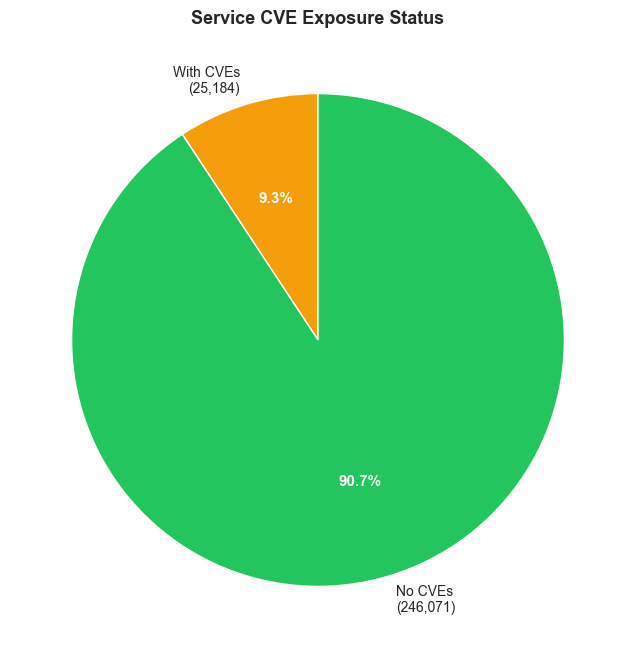

In [41]:
# CVE analysis from service data
cve_column = 'service.cves'
cve_count_column = 'service.cves_count'

if cve_column in df.columns:
    services_with_cve = df[cve_column].notna().sum()
    services_without_cve = len(df) - services_with_cve

    print("\n" + "="*60)
    print("CVE EXPOSURE OVERVIEW")
    print("="*60)
    print(f"{'Services with CVEs':.<40} {services_with_cve:>8,} ({services_with_cve/len(df)*100:>5.2f}%)")
    print(f"{'Services without CVEs':.<40} {services_without_cve:>8,} ({services_without_cve/len(df)*100:>5.2f}%)")

    # Parse CVE details from service data
    all_cves = []
    kev_cves = []

    for idx, row in df[df[cve_column].notna()].iterrows():
        cves_str = str(row[cve_column])

        # Try to parse as JSON-like structure or extract CVE IDs
        try:
            # If it's a string representation of a list
            import ast
            import json

            # Try JSON first
            try:
                cves_list = json.loads(cves_str)
            except:
                # Try ast.literal_eval for Python-style lists
                try:
                    cves_list = ast.literal_eval(cves_str)
                except:
                    # Skip if can't parse
                    continue

            # Extract CVE details
            if isinstance(cves_list, list):
                for cve_item in cves_list:
                    if isinstance(cve_item, dict):
                        cve_id = cve_item.get('id', '')
                        cvss_score = cve_item.get('cvss', 0)
                        is_kev = cve_item.get('is_kev', False)

                        all_cves.append({
                            'cve_id': cve_id,
                            'cvss': float(cvss_score) if cvss_score else 0.0,
                            'is_kev': is_kev
                        })

                        if is_kev:
                            kev_cves.append({
                                'cve_id': cve_id,
                                'cvss': float(cvss_score) if cvss_score else 0.0
                            })
        except:
            pass

    # Create DataFrame for analysis
    cve_details_df = pd.DataFrame(all_cves)

    if len(cve_details_df) > 0:
        # Remove duplicates (same CVE may appear on multiple services)
        unique_cves = cve_details_df.drop_duplicates(subset=['cve_id'])

        print(f"\n{'Total CVE instances':.<40} {len(cve_details_df):>8,}")
        print(f"{'Unique CVEs':.<40} {len(unique_cves):>8,}")

        # CVSS Score Distribution by Severity
        print("\n" + "="*60)
        print("CVSS SEVERITY DISTRIBUTION")
        print("="*60)

        # Define severity ranges
        def categorize_severity(score):
            if pd.isna(score) or score == 0:
                return 'UNSCORED'
            elif 0.1 <= score <= 3.9:
                return 'LOW'
            elif 4.0 <= score <= 6.9:
                return 'MEDIUM'
            elif 7.0 <= score <= 8.9:
                return 'HIGH'
            elif 9.0 <= score <= 10.0:
                return 'CRITICAL'
            else:
                return 'UNSCORED'

        unique_cves['severity'] = unique_cves['cvss'].apply(categorize_severity)

        # Count by severity
        severity_counts = unique_cves['severity'].value_counts()
        severity_order = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'UNSCORED']

        print(f"\n{'Severity':<15} {'Score Range':<15} {'Count':>10} {'Percentage':>12}")
        print("-"*60)

        severity_stats = {}
        for sev in severity_order:
            count = severity_counts.get(sev, 0)
            pct = (count / len(unique_cves) * 100) if len(unique_cves) > 0 else 0

            score_range = {
                'CRITICAL': '9.0-10.0',
                'HIGH': '7.0-8.9',
                'MEDIUM': '4.0-6.9',
                'LOW': '0.1-3.9',
                'UNSCORED': 'N/A'
            }

            severity_stats[sev] = {'count': count, 'percentage': pct}

            if count > 0:
                print(f"{sev:<15} {score_range[sev]:<15} {count:>10,} {pct:>11.2f}%")

        print("-"*60)
        print(f"{'TOTAL':<31} {len(unique_cves):>10,} {100.00:>11.2f}%")

        # CVSS Score Statistics
        scored_cves = unique_cves[unique_cves['cvss'] > 0]

        if len(scored_cves) > 0:
            print(f"\n{'Mean CVSS Score':.<40} {scored_cves['cvss'].mean():>8.2f}")
            print(f"{'Median CVSS Score':.<40} {scored_cves['cvss'].median():>8.2f}")
            print(f"{'Highest CVSS Score':.<40} {scored_cves['cvss'].max():>8.2f}")
            print(f"{'Lowest CVSS Score':.<40} {scored_cves['cvss'].min():>8.2f}")

        # KEV Analysis
        print("\n" + "="*60)
        print("KEV (KNOWN EXPLOITED VULNERABILITIES) ANALYSIS")
        print("="*60)

        kev_count = unique_cves['is_kev'].sum()
        non_kev_count = len(unique_cves) - kev_count
        kev_pct = (kev_count / len(unique_cves) * 100) if len(unique_cves) > 0 else 0

        print(f"\n{'KEV CVEs (actively exploited)':.<40} {kev_count:>8,} ({kev_pct:>5.2f}%)")
        print(f"{'Non-KEV CVEs':.<40} {non_kev_count:>8,} ({100-kev_pct:>5.2f}%)")

        if kev_count > 0:
            kev_df = unique_cves[unique_cves['is_kev'] == True]

            print(f"\nKEV Severity Breakdown:")
            kev_severity = kev_df['severity'].value_counts()
            for sev in severity_order:
                if sev in kev_severity.index:
                    count = kev_severity[sev]
                    pct = (count / kev_count * 100)
                    print(f"  {sev:<15} {count:>6,} ({pct:>5.2f}%)")

            # KEV score statistics
            kev_scored = kev_df[kev_df['cvss'] > 0]
            if len(kev_scored) > 0:
                print(f"\nKEV CVSS Statistics:")
                print(f"  Mean CVSS:   {kev_scored['cvss'].mean():.2f}")
                print(f"  Median CVSS: {kev_scored['cvss'].median():.2f}")
                print(f"  Max CVSS:    {kev_scored['cvss'].max():.2f}")
        else:
            print("\n✓ No KEV vulnerabilities found (good news!)")

        print("="*60)

    # ========================================================================
    # Visualize CVE exposure - Individual Charts
    # ========================================================================
    
    # Chart 1: CVE Exposure Pie
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    

    # Define colors
    severity_colors_map = {
        'CRITICAL': '#EF4444',      # Red
        'HIGH': '#F59E0B',          # Yellow
        'MEDIUM': '#D97706',        # Darker Amber
        'LOW': '#22C55E',           # Emerald green
        'UNSCORED': '#9CA3AF'       # Gray
    }

    # 1. Pie chart: Services with/without CVEs
    sizes = [services_with_cve, services_without_cve]
    labels = [f'With CVEs\n({services_with_cve:,})', f'No CVEs\n({services_without_cve:,})']
    colors = ['#F59E0B', '#22C55E']  # Yellow (warning) vs Green (safe)

    wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                                         colors=colors, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    ax1.set_title('Service CVE Exposure Status', fontsize=13, fontweight='bold')

# Chart 2: Severity Distribution
    fig2, ax2 = plt.subplots(figsize=(12, 8))

    # 2. Bar chart: Severity distribution (simple)
    severity_plot_order = [s for s in severity_order if severity_stats[s]['count'] > 0]
    severity_counts_plot = [severity_stats[s]['count'] for s in severity_plot_order]
    severity_colors_plot = [severity_colors_map[s] for s in severity_plot_order]

    bars = ax2.bar(severity_plot_order, severity_counts_plot,
                  color=severity_colors_plot, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Number of CVEs', fontsize=11)
    ax2.set_xlabel('Severity Level', fontsize=11)
    ax2.set_title('CVE Severity Distribution', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    for bar, count in zip(bars, severity_counts_plot):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.savefig(output_dir / 'viz_cve_severity.jpg', dpi=300, bbox_inches='tight')
    print('✓ Saved: viz_cve_severity.jpg')
    plt.close()

    
# Chart 3: KEV vs Non-KEV by Severity (Stacked Bar)
    # Create KEV breakdown by severity
    kev_by_severity = {}
    non_kev_by_severity = {}

    for sev in severity_order:
        if sev == 'UNSCORED':
            continue  # Skip unscored for this chart

        sev_df = unique_cves[unique_cves['severity'] == sev]
        kev_count_sev = sev_df['is_kev'].sum()
        non_kev_count_sev = len(sev_df) - kev_count_sev

        kev_by_severity[sev] = kev_count_sev
        non_kev_by_severity[sev] = non_kev_count_sev

    # Filter to only severities with data
    severity_with_data = [s for s in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
                         if kev_by_severity.get(s, 0) + non_kev_by_severity.get(s, 0) > 0]

    if severity_with_data:
        x_pos = np.arange(len(severity_with_data))
        non_kev_counts = [non_kev_by_severity.get(s, 0) for s in severity_with_data]
        kev_counts = [kev_by_severity.get(s, 0) for s in severity_with_data]

        fig3, ax3 = plt.subplots(figsize=(12, 8))

        # Create stacked bars
        bars1 = ax3.bar(x_pos, non_kev_counts,
                   color='#6B7280', edgecolor='black', linewidth=1,
                   label='Non-KEV')
    bars2 = ax3.bar(x_pos, kev_counts, bottom=non_kev_counts,
                   color='#DC2626', edgecolor='black', linewidth=1,
                   label='KEV (Exploited)', hatch='///')

    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(severity_with_data)
    ax3.set_ylabel('Number of CVEs', fontsize=11)
    ax3.set_xlabel('Severity Level', fontsize=11)
    ax3.set_title('KEV vs Non-KEV by Severity', fontsize=13, fontweight='bold')
    ax3.legend(loc='upper right', framealpha=0.9)
    ax3.grid(axis='y', alpha=0.3)

    # Add count labels
    for i, (bar1, bar2, non_kev, kev_val) in enumerate(zip(bars1, bars2, non_kev_counts, kev_counts)):
        # Non-KEV label (in middle of non-KEV bar)
        if non_kev > 0:
            ax3.text(bar1.get_x() + bar1.get_width()/2., non_kev/2,
                    f'{non_kev}', ha='center', va='center',
                    fontweight='bold', fontsize=9, color='white')

        # KEV label (in middle of KEV bar)
        if kev_val > 0:
            ax3.text(bar2.get_x() + bar2.get_width()/2., non_kev + kev_val/2,
                    f'{kev_val}', ha='center', va='center',
                    fontweight='bold', fontsize=9, color='white')

        # Total on top
        total = non_kev + kev_val
        if total > 0:
            ax3.text(bar2.get_x() + bar2.get_width()/2., total,
                    f'{total}', ha='center', va='bottom',
                    fontweight='bold', fontsize=10)

    plt.tight_layout()
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_cve_kev_severity.jpg', dpi=300, bbox_inches='tight')
    print('✓ Saved: viz_cve_kev_severity.jpg')
    plt.close()
    
# Chart 4: KEV vs Non-KEV Pie
    fig4, ax4 = plt.subplots(figsize=(10, 8))

    kev_count = unique_cves['is_kev'].sum()
    non_kev_count = len(unique_cves) - kev_count
    kev_sizes = [kev_count, non_kev_count]
    kev_labels = [f'KEV\n({kev_count:,})\nExploited', f'Non-KEV\n({non_kev_count:,})\nNot Exploited']
    kev_colors = ['#DC2626', '#6B7280']

    wedges, texts, autotexts = ax4.pie(kev_sizes, labels=kev_labels, autopct='%1.1f%%',
                                             colors=kev_colors, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
        ax4.set_title('Known Exploited Vulnerabilities (KEV)', fontsize=13, fontweight='bold')

        # Add KEV warning annotation if any KEV found
        if kev_count > 0:
            ax4.text(0, -1.4, f' {kev_count} CVEs actively exploited in the wild',
                    ha='center', fontsize=10, color='#DC2626', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='#FEE2E2', edgecolor='#DC2626', linewidth=2))

    plt.tight_layout()
    
    plt.tight_layout()
    plt.savefig(output_dir / 'viz_cve_kev.jpg', dpi=300, bbox_inches='tight')
    print('✓ Saved: viz_cve_kev.jpg')
    plt.close()


### 7.2 CVE Distribution by Service


In [42]:
# ========================================
# CVE-to-Service Correlation Analysis
# ========================================

print("\n" + "="*60)
print("CVE-TO-SERVICE CORRELATION ANALYSIS")
print("="*60)

# This analysis links CVEs back to the services where they appear
if 'service.cves' in df.columns:
    # Filter services that have CVEs
    services_with_cves = df[df['service.cves'].notna()].copy()
    
    if len(services_with_cves) > 0:
        print(f"\nServices with CVEs: {len(services_with_cves):,}")
        
        # Top ports with CVEs
        print("\n--- TOP 10 PORTS WITH CVE EXPOSURE ---")
        port_cve_counts = services_with_cves['service.port'].value_counts().head(10)
        for idx, (port, count) in enumerate(port_cve_counts.items(), 1):
            pct = count / len(services_with_cves) * 100
            print(f"{idx}.\tPort {port}\t{count:,}\t({pct:.2f}% of vulnerable services)")
        
        # Top protocols with CVEs
        if 'protocol_enhanced' in df.columns:
            print("\n--- TOP 10 PROTOCOLS WITH CVE EXPOSURE ---")
            protocol_cve_counts = services_with_cves['protocol_enhanced'].value_counts().head(10)
            for idx, (protocol, count) in enumerate(protocol_cve_counts.items(), 1):
                pct = count / len(services_with_cves) * 100
                print(f"{idx}.\t{protocol}\t{count:,}\t({pct:.2f}% of vulnerable services)")
        
        # Geographic distribution of vulnerabilities
        if 'geo.country_name' in df.columns:
            print("\n--- TOP 10 COUNTRIES WITH VULNERABLE SERVICES ---")
            country_cve_counts = services_with_cves['geo.country_name'].value_counts().head(10)
            for idx, (country, count) in enumerate(country_cve_counts.items(), 1):
                pct = count / len(services_with_cves) * 100
                print(f"{idx}.\t{country}\t{count:,}\t({pct:.2f}% of vulnerable services)")
    else:
        print("No services with CVE data found.")
else:
    print("CVE column not found in dataset.")



CVE-TO-SERVICE CORRELATION ANALYSIS

Services with CVEs: 25,184

--- TOP 10 PORTS WITH CVE EXPOSURE ---
1.	Port 80	13,972	(55.48% of vulnerable services)
2.	Port 443	10,371	(41.18% of vulnerable services)
3.	Port 22	146	(0.58% of vulnerable services)
4.	Port 8443	109	(0.43% of vulnerable services)
5.	Port 21	107	(0.42% of vulnerable services)
6.	Port 10022	104	(0.41% of vulnerable services)
7.	Port 8880	22	(0.09% of vulnerable services)
8.	Port 8080	17	(0.07% of vulnerable services)
9.	Port 15021	16	(0.06% of vulnerable services)
10.	Port 25	12	(0.05% of vulnerable services)

--- TOP 10 PROTOCOLS WITH CVE EXPOSURE ---
1.	http	19,202	(76.25% of vulnerable services)
2.	https	5,530	(21.96% of vulnerable services)
3.	ssh	302	(1.20% of vulnerable services)
4.	ftp	111	(0.44% of vulnerable services)
5.	rdp	21	(0.08% of vulnerable services)
6.	smtp	18	(0.07% of vulnerable services)

--- TOP 10 COUNTRIES WITH VULNERABLE SERVICES ---
1.	United States	16,123	(64.02% of vulnerable services)
2.	Th

### 7.3 CVE Distribution by Tags


In [43]:
# Combined Analysis: Tags × Port × Protocol
print("\n" + "="*80)
print("COMBINED ANALYSIS: TAGS × PORT × PROTOCOL")
print("="*80)

tag_column = 'service.fingerprints.tags'
port_column = 'service.port'
protocol_column = 'service.protocol'

if all(col in df.columns for col in [tag_column, port_column, protocol_column]):
    # Filter to services that have tags
    tagged_services = df[df[tag_column].notna()].copy()

    print(f"\nAnalyzing {len(tagged_services):,} services with tags...")

    # Create combinations of port/protocol
    tagged_services['port_protocol'] = (
        tagged_services[port_column].astype(str) + '/' +
        tagged_services[protocol_column].astype(str)
    )

    # Extract individual tags for each service
    def extract_tags(tag_str):
        if pd.isna(tag_str):
            return []
        tags = str(tag_str).strip('[]').replace("'", "").split(',')
        return [tag.strip() for tag in tags if tag.strip()]

    tagged_services['individual_tags'] = tagged_services[tag_column].apply(extract_tags)

    # Explode to get one row per tag
    exploded = tagged_services.explode('individual_tags')
    exploded = exploded[exploded['individual_tags'].notna()].copy()

    # Count tag × port/protocol combinations
    tag_port_protocol = exploded.groupby(['individual_tags', 'port_protocol']).size().reset_index(name='count')
    tag_port_protocol = tag_port_protocol.sort_values('count', ascending=False)

    print(f"\nTotal unique tag × port/protocol combinations: {len(tag_port_protocol):,}")
    print(f"\nTop 30 Tag × Port/Protocol Combinations:")
    print("-" * 80)
    print(f"{'Tag':<25} {'Port/Protocol':<20} {'Count':>10} {'% of Tagged':>12}")
    print("-" * 80)

    for idx, row in tag_port_protocol.head(30).iterrows():
        tag = row['individual_tags']
        port_proto = row['port_protocol']
        count = row['count']
        pct = (count / len(tagged_services)) * 100
        print(f"{tag:<25} {port_proto:<20} {count:>10,} {pct:>11.2f}%")

    print("=" * 80)


COMBINED ANALYSIS: TAGS × PORT × PROTOCOL

Analyzing 11,133 services with tags...

Total unique tag × port/protocol combinations: 99

Top 30 Tag × Port/Protocol Combinations:
--------------------------------------------------------------------------------
Tag                       Port/Protocol             Count  % of Tagged
--------------------------------------------------------------------------------
Cloud                     80/http                   5,079       45.62%
Cloud                     443/http                  4,873       43.77%
DevOps                    6443/http                   256        2.30%
Redirect                  80/http                     239        2.15%
Cloud;Redirect            80/http                     192        1.72%
Redirect;Cloud            80/http                     128        1.15%
Redirect                  443/http                     57        0.51%
Cloud                     8443/http                    42        0.38%
PQC SSH                

## 8. Analysis Summary


In [44]:
# Generate final summary
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

output_files = sorted(list(output_dir.glob('analyses_1_*')))
print(f"\nGenerated {len(output_files)} output files:")
print("-"*80)

for i, file in enumerate(output_files, 1):
    file_size = file.stat().st_size
    if file_size > 1024*1024:
        size_str = f"{file_size/(1024*1024):.2f} MB"
    elif file_size > 1024:
        size_str = f"{file_size/1024:.2f} KB"
    else:
        size_str = f"{file_size} bytes"
    
    print(f"{i:2d}. {file.name:<50} ({size_str})")

print("="*80)
print(f"All outputs saved to: {output_dir.absolute()}")
print("="*80)

# Save completion timestamp
with open(output_dir / 'analyses_1_completion.txt', 'w') as f:
    f.write(f"Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total output files: {len(output_files)}\n")
    f.write(f"\nProcessed data:\n")
    f.write(f"- Unique IPs: {unique_ips:,}\n")

print(f"\n✓ Completion log saved to: {output_dir / 'analyses_1_completion.txt'}")


ANALYSIS COMPLETE!

Generated 4 output files:
--------------------------------------------------------------------------------
 1. analyses_1_completion.txt                          (108 bytes)
 2. analyses_1_cve_exposure.jpg                        (132.28 KB)
 3. analyses_1_cve_exposure_enhanced.jpg               (558.93 KB)
 4. analyses_1_tag_statistics.csv                      (735 bytes)
All outputs saved to: H:\_HHS_thesis\GitHub\thesis\v1\output\1_data_statistics

✓ Completion log saved to: output\1_data_statistics\analyses_1_completion.txt
